# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-Learning.

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matris. The second class, GameExperience.py, stores the episodes - that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-Learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code instruction blocks to understand the code that you have been given.

# UPDATES: 
## This notebook also includes cumulative reward tracking and support for comparing different exploration rates (epsilon values).

In [1]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation, PReLU
from keras.optimizers import SGD, Adam, RMSprop
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

The following block contains an 8x8 matrix that will be used as a maze object:

In [2]:
maze = np.array([
    [1., 0., 1., 1., 1., 1., 1., 1.],
    [1., 0., 1., 1., 1., 0., 1., 1.],
    [1., 1., 1., 1., 0., 1., 0., 1.],
    [1., 1., 1., 0., 1., 1., 1., 1.],
    [1., 1., 0., 1., 1., 1., 1., 1.],
    [1., 1., 1., 0., 1., 0., 0., 0.],
    [1., 1., 1., 0., 1., 1., 1., 1.],
    [1., 1., 1., 1., 0., 1., 1., 1.]
])

This helper function allows a visual representation of the maze object:

In [3]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down.

While the agent primarily learns by experience through exploitation, often the agent can choos to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by the epsilon. THis value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see hwo the algorithm performs.

In [4]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. THe resulting updated environment is visualized.

reward= -0.04


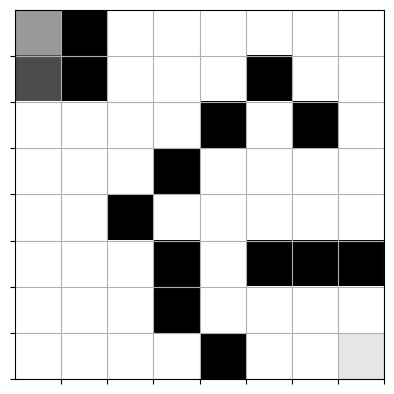

In [5]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze);

In [6]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmac(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

The function helps you determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [7]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [8]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

# UPDATE
## In addition, a reward history list was added to store a data structure which will be used to plot reward trends by exploration rate

In [9]:
def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon 

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    # history of win/lose game
    win_history = []
    # total rewards per epoch
    reward_history = []
    hsize = qmaze.maze.size // 2  # history window size
    win_rate = 0.0

	# For each epoch:
    for epoch in range(n_epoch):
        loss = 0.0
        n_episodes = 0
        cumulative_reward = 0  # Track total reward earned this epoch

        # Reset environment with agent at a random free cell
        agent_cell = random.choice(qmaze.free_cells)
        qmaze.reset(agent_cell)
        envstate = qmaze.observe()
    #    While state is not game over:

    #        Action = randomly choose action (left, right, up, down) either by exploration or by exploitation
    #        envstate, reward, game_status = qmaze.act(action)
        loss = 0
        n_episodes = 0
        
        while qmaze.game_status() == 'not_over':
            previous_envstate = envstate
            valid_actions = qmaze.valid_actions()
    #       Next action
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(envstate))
            envstate, reward, game_status = qmaze.act(action)
            cumulative_reward += reward

            # Store experience and train
            episode = [previous_envstate, action, reward, envstate, game_status]
    #       Store episode in Experience replay object 
            experience.remember(episode)
	#        Train neural network model and evaluate loss
            inputs, targets = experience.get_data(data_size=data_size)
            h = model.fit(inputs, targets, epochs=1, verbose=0)
            loss += h.history['loss'][0]
            n_episodes += 1
	#       append 1 if win, 0 if loss
            if game_status in ('win', 'lose'):
                win_history.append(1 if game_status == 'win' else 0)
                break

        reward_history.append(cumulative_reward)
        win_rate = sum(win_history[-hsize:]) / hsize

        # logging output per epoch
		#   Print epoch, loss, episodes, win count, win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        print(f"Epoch: {epoch+1}/{n_epoch} | Loss: {loss:.4f} | Reward: {cumulative_reward:.2f} | "
              f"Episodes: {n_episodes} | Win rate: {win_rate:.3f} | Time: {t}")

        # Reduce exploration once win rate is high
        if win_rate > 0.9: epsilon = 0.05
        # Stop training if 100% win rate is achieved
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("100%% win rate at epoch: %d" % (epoch,))
            break
    return model, reward_history
    
    # Calculate time to train
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds



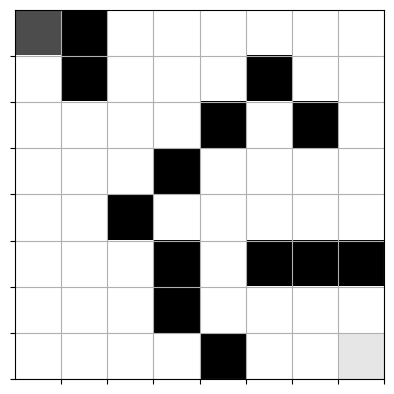

In [10]:
qmaze = TreasureMaze(maze)
show(qmaze)

# UPDATE
## Time formatting was added to make the logs easier to understand

In [11]:
# Format time in hh:mm:ss for human readability
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

# UPDATE
## This method utilizes matplotlib to display a comparison of the cumulative award per epoch at each exploration rate tested

In [12]:
def plot_reward_history(reward_histories, epsilon_values):
    """
    Plots cumulative reward per epoch for each exploration rate tested.
    """
    plt.figure(figsize=(12, 6))
    
    # Plot each epsilon's reward trend
    for rewards, eps in zip(reward_histories, epsilon_values):
        plt.plot(rewards, label=f"Epsilon={eps}")
    
    plt.xlabel("Epoch")
    plt.ylabel("Cumulative Reward")
    plt.title("Training Reward Over Time by Epsilon")
    plt.legend()
    plt.grid(True)
    plt.show()

# UPDATE

## This method runs multiple training sessions with different exploration rates to generate the data that compares cumulative reward trends at each rate

In [13]:
def run_experiment(maze, epsilon_values=[0.1, 0.01], epochs=2):
    """
    Runs training for each epsilon setting and plots reward trends.
    """
    reward_histories = []

    for eps in epsilon_values:
        print(f"\nTraining with epsilon = {eps}")
        global epsilon
        epsilon = eps  # Set current exploration rate
        
        model = build_model(maze)  # Create a fresh neural network
        _, reward_history = qtrain(model, maze, n_epoch=epochs, max_memory=8*maze.size, data_size=32)
        
        reward_histories.append(reward_history)

    # Visualize and compare results
    return plot_reward_history(reward_histories, epsilon_values)


In [ ]:
reward_history = run_experiment(maze)


Training with epsilon = 0.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━